In [ ]:
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 4.4 MB 34.8 MB/s 
     |████████████████████████████████| 596 kB 65.2 MB/s 
     |████████████████████████████████| 6.6 MB 71.4 MB/s 
     |████████████████████████████████| 101 kB 12.8 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


In [ ]:
import torch
from torch.utils.data import (TensorDataset, DataLoader,
                              RandomSampler, SequentialSampler)

from transformers import BertTokenizer, BertConfig
from transformers import BertForSequenceClassification
from transformers import AdamW, get_linear_schedule_with_warmup
from transformers import AutoModel, AutoTokenizer

from distutils.version import LooseVersion as LV

from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from tqdm import tqdm

import io

import pandas as pd
import numpy as np
import itertools

import matplotlib
matplotlib.use('Agg')
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
from sklearn.preprocessing import LabelEncoder
import random

In [ ]:
if torch.cuda.is_available():
    device = torch.device('cuda')
    devicename = '['+torch.cuda.get_device_name(0)+']'
else:
    device = torch.device('cpu')
    devicename = ""
    
print('Using PyTorch version:', torch.__version__,
      'Device:', device, devicename)
assert(LV(torch.__version__) >= LV("1.0.0"))

Using PyTorch version: 1.11.0+cu113 Device: cuda [Tesla T4]


In [ ]:
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


In [ ]:
df_test = pd.read_csv("/content/drive/Shareddrives/TextAnalytics_project/dataset_ironita_2018/Data/processed_text_test.csv")
df_train = pd.read_csv("/content/drive/Shareddrives/TextAnalytics_project/dataset_ironita_2018/Data/processed_text_train.csv")

In [ ]:
df_train.head()

,id,text,irony,sarcasm,topic,lemmatized_text,cleaned_text,cleaned_text_mention_hashtag
0,8.111568e+17,"Zurigo, trovato morto il presunto autore della...",0.0,0.0,HSC,Zurigo trovare morire presumere autore sparato...,zurigo trovato morto presunto autore sparatori...,zurigo trovato morto presunto autore sparatori...
1,8.111831e+17,"Zurigo, trovato morto il presunto autore della...",0.0,0.0,HSC,Zurigo trovare morire presumere autore sparato...,zurigo trovato morto presunto autore sparatori...,zurigo trovato morto presunto autore sparatori...
2,8.263806e+17,"Zingari..i soliti ""MERDOSI""..#cacciamolivia Ro...",0.0,0.0,HSC,zingaro solito merdoso #cacciamolivia Roma rom...,zingari soliti merdosi #cacciamolivia roma rom...,zingari soliti merdosi @hashtag roma rom aggre...
3,8.448712e+17,"Zingari di merda,tutti al muro...bastardi Spar...",0.0,0.0,HSC,zingaro merda muro bastardo sparare carabinier...,zingari merda muro bastardi sparano carabinier...,zingari merda muro bastardi sparano carabinier...
4,5.097128e+17,zero notizie decreto #tfaordinario II ciclo ze...,1.0,0.0,TW-BS,zero notizia decreto #tfaordinario II ciclo ze...,zero notizie decreto #tfaordinario ii ciclo ze...,zero notizie decreto @hashtag ii ciclo zero no...
...,...,...,...,...,...,...,...,...
3972,1.366107e+17,Casini:Trovare un'intesa tra forze politiche o...,0.0,0.0,TW-SENTIPOLC,Casini trovare intendere forza politico oppost...,casini trovare intesa forze politiche opposte ...,casini trovare intesa forze politiche opposte ...
3973,1.465388e+17,Cambiare tutto per non cambiare niente sembra ...,0.0,0.0,TW-SENTIPOLC,cambiare cambiare niente sembrare linea politi...,cambiare cambiare niente sembra linea politica...,cambiare cambiare niente sembra linea politica...
3974,1.557581e+17,Alcuni mettono mani nelle tasche degli italian...,0.0,0.0,TW-SENTIPOLC,alcun mettere mano tasca italiano evasore risp...,alcuni mettono mani tasche italiani evasori ri...,alcuni mettono mani tasche italiani evasori ri...
3975,8.368583e+17,A parte che la dieta di #Salvini dovrebbe ess...,1.0,0.0,HSC,parte dieta #Salvini dovere rigorosamente pada...,parte dieta #salvini dovrebbe rigorosamente pa...,parte dieta @hashtag dovrebbe rigorosamente pa...


In [ ]:
X_train = df_train['text']
y_train = df_train["irony"]
X_test = df_test['text']
y_test = df_test["irony"]

In [ ]:
labels_train = y_train
labels_test = y_test

# Preparation of text

[CLS] sta ad indicare l'inizio della frase

In [ ]:
sentences_train = ["[CLS] " + s for s in X_train]
sentences_test = ["[CLS] " + s for s in X_test]

In [ ]:
sentences_train[1]

'[CLS] Zurigo, trovato morto il presunto autore della sparatoria nel centro islamico - https://t.co/XMrEqPnV6w tramite https://t.co/zAAl3RtO5F'

We decided to use **bert-base-italian-cased** because we have Italian tweets

In [ ]:
model_name = "dbmdz/bert-base-italian-cased"

tokenizer = AutoTokenizer.from_pretrained(model_name, do_lower_case=True)
model = AutoModel.from_pretrained(model_name)
tokenizer

Downloading:   0%|          | 0.00/59.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/433 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/230k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/422M [00:00<?, ?B/s]

Some weights of the model checkpoint at dbmdz/bert-base-italian-cased were not used when initializing BertModel: ['cls.predictions.decoder.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


PreTrainedTokenizerFast(name_or_path='dbmdz/bert-base-italian-cased', vocab_size=31102, model_max_len=512, is_fast=True, padding_side='right', truncation_side='right', special_tokens={'unk_token': '[UNK]', 'sep_token': '[SEP]', 'pad_token': '[PAD]', 'cls_token': '[CLS]', 'mask_token': '[MASK]'})

Tokenization of test and train

In [ ]:
tokenized_train = [tokenizer.tokenize(s) for s in tqdm(sentences_train)]
tokenized_test  = [tokenizer.tokenize(s) for s in tqdm(sentences_test)]

100%|██████████| 872/872 [00:00<00:00, 6566.79it/s]


In [ ]:
print("Tokenized tweet: ", (tokenized_train[0]) )
print("Original tweet: ", X_train.values[0])

Tokenized tweet:  ['[CLS]', 'zu', '##rig', '##o', ',', 'trovato', 'morto', 'il', 'presunto', 'autore', 'della', 'sparatoria', 'nel', 'centro', 'islamico', '#', '20', '##dice', '##mbre', 'http', '##s', ':', '/', '/', 't', '.', 'co', '/', 'r', '##b', '##j', '##vu', '##i', '##8', '##r', '##j', '##2']
Original tweet:  Zurigo, trovato morto il presunto autore della sparatoria nel centro islamico #20dicembre https://t.co/rBjvUi8RJ2


Set the maximum lengths (BERT have a maximum number of token we can pass)

and add [SEP] at the end of the sentence

In [ ]:
MAX_LEN_TRAIN, MAX_LEN_TEST = 128, 512

tokenized_train = [t[:(MAX_LEN_TRAIN-1)]+['SEP'] for t in tokenized_train]
tokenized_test  = [t[:(MAX_LEN_TEST-1)]+['SEP'] for t in tokenized_test]

print ("The truncated tokenized first training sentence:")
print (tokenized_train[11])

The truncated tokenized first training sentence:
['[CLS]', 'wi', '##fi', 'assente', ',', 'nuovi', 'modi', 'di', 'fare', 'scuola', ',', '(', 'im', ')', 'preparazione', 'del', 'corpo', 'docente', '.', '#', 'la', '##bu', '##ona', '##sc', '##uola', 'http', ':', '/', '/', 't', '.', 'co', '/', 'e', '##y', '##j', '##sc', '##f', '##q', '##i', '##7', '##j', '@', 'star', '##tu', '##p', '_', 'itali', '##a', '#', 'is', '##cho', '##ol', 'SEP']


In [ ]:
ids_train = [tokenizer.convert_tokens_to_ids(t) for t in tokenized_train]
ids_train = np.array([np.pad(i, (0, MAX_LEN_TRAIN-len(i)),
                             mode='constant') for i in ids_train])

ids_test = [tokenizer.convert_tokens_to_ids(t) for t in tokenized_test]
ids_test = np.array([np.pad(i, (0, MAX_LEN_TEST-len(i)),
                            mode='constant') for i in ids_test])

print ("The indices of the first training sentence:")
print (ids_train[0])

The indices of the first training sentence:
[  102  4682   916 30879  1307  2088  2762   162 27577  7773   213 24688
   207  1472 30594   864  1222  1763   810 15235 30884  1587  1927  1927
   154   697   398  1927  1346 30897 30957 21586 30877 30935 30882 30957
 30912   101     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0]


Attention mask: 1 if there is a token, 0 otherwise

In [ ]:
amasks_train, amasks_test = [], []

for seq in ids_train:
  seq_mask = [float(i>0) for i in seq]
  amasks_train.append(seq_mask)

for seq in ids_test:
  seq_mask = [float(i>0) for i in seq]
  amasks_test.append(seq_mask)

In [ ]:
labels_train = [1 if value else 0 for value in y_train]
labels_test  = [1 if value else 0 for value in y_test]

Creation of validation set

In [ ]:
(train_inputs, validation_inputs,
 train_labels, validation_labels) = train_test_split(ids_train, labels_train,
                                                     random_state=42,
                                                     test_size=0.1)
(train_masks, validation_masks,
 _, _) = train_test_split(amasks_train, ids_train,
                          random_state=42, test_size=0.1)

train_inputs = torch.tensor(train_inputs)
train_labels = torch.tensor(train_labels)
train_masks  = torch.tensor(train_masks)
validation_inputs = torch.tensor(validation_inputs)
validation_labels = torch.tensor(validation_labels)
validation_masks  = torch.tensor(validation_masks)
test_inputs = torch.tensor(ids_test)
test_labels = torch.tensor(labels_test)
test_masks  = torch.tensor(amasks_test)

In [ ]:
BATCH_SIZE = 32

print('Datasets:')
print('Train: ', end="")
train_data = TensorDataset(train_inputs, train_masks,
                           train_labels)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler,
                              batch_size=BATCH_SIZE)
print(len(train_data), 'documents')

print('Validation: ', end="")
validation_data = TensorDataset(validation_inputs, validation_masks,
                                validation_labels)
validation_sampler = SequentialSampler(validation_data)
validation_dataloader = DataLoader(validation_data,
                                   sampler=validation_sampler,
                                   batch_size=BATCH_SIZE)
print(len(validation_data), 'documents')

print('Test: ', end="")
test_data = TensorDataset(test_inputs, test_masks, test_labels)
test_sampler = SequentialSampler(test_data)
test_dataloader = DataLoader(test_data, sampler=test_sampler,
                             batch_size=BATCH_SIZE)
print(len(test_data), 'documents')

Datasets:
Train: 3579 documents
Validation: 398 documents
Test: 872 documents


# BERT initialization

## Training

In [ ]:
def build_model(model, epochs, weight_decay, lr):
  warmup_steps=int(0.2*len(train_dataloader))
  no_decay = ['bias', 'LayerNorm.weight']
  optimizer_grouped_parameters = [
      {'params': [p for n, p in model.named_parameters()
                  if not any(nd in n for nd in no_decay)],
      'weight_decay': weight_decay},
      {'params': [p for n, p in model.named_parameters()
                  if any(nd in n for nd in no_decay)],
      'weight_decay': 0.0}
  ]
  optimizer = AdamW(optimizer_grouped_parameters, lr=lr,  eps=1e-8)
  scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=warmup_steps,
                                  num_training_steps =len(train_dataloader)*epochs)
  
  return optimizer, scheduler

In [ ]:
def train(model, optimizer, scheduler, epochs, loss_vector=None, log_interval=200):
  # Set model to training mode
  model.train()

  # Loop over each batch from the training set


  for step, batch in enumerate(train_dataloader):
    b_input_ids = batch[0].to(device) #batch[0] - input_ids
    b_input_mask = batch[1].to(device) #batch[1] - attention_masks
    b_labels = batch[2].to(device) #batch[2] - labels


    # Zero gradient buffers
    optimizer.zero_grad()

    # Forward pass
    model1 = model(b_input_ids, 
                             token_type_ids=None, 
                             attention_mask=b_input_mask, 
                            labels=b_labels) 
    loss = model1.loss
    if loss_vector is not None:
        loss_vector.append(loss.item())

    # Backward pass
    loss.backward()
    
    # Update weights
    optimizer.step()
    scheduler.step()

    if step % log_interval == 0:
        print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, step * len(b_input_ids),
                len(train_dataloader.dataset),
                100. * step / len(train_dataloader), loss))

def evaluate(model, loader):
  model.eval()

  n_correct, n_all = 0, 0
  full_predictions = np.array([])
  full_labels = np.array([])

  for batch in loader:
    batch = tuple(t.to(device) for t in batch)
    b_input_ids, b_input_mask, b_labels = batch

    with torch.no_grad():
      outputs = model(b_input_ids, token_type_ids=None,
                      attention_mask=b_input_mask)
      logits = outputs[0]

    logits = logits.detach().cpu().numpy()
    predictions = np.argmax(logits, axis=1)

    labels = b_labels.to('cpu').numpy()
    n_correct += np.sum(predictions == labels)
    n_all += len(labels)
    full_predictions = np.concatenate((full_predictions, predictions), axis=0)
    full_labels = np.concatenate((full_labels, labels), axis=0)


  print('F1 Score: {:.4f}'.format(f1_score(full_labels, full_predictions, average="macro")))
  
  print('Accuracy: [{}/{}] {:.4f}'.format(n_correct, n_all,
                                          n_correct/n_all))

In [ ]:
param_grid = {
    'epochs': [2, 3, 4],
    'weight_decay': [0.01, 0.1, 0.001],
    'lr': [2e-5, 3e-5, 4e-5]
}

In [ ]:
for params in itertools.product(*[l for l in param_grid.values()]):
    d= dict(zip(param_grid.keys(), params))
    print('Hyperparameters--> '+'Epochs: '+str(d['epochs'])+'- Weight_decay: '+str(d['weight_decay'])+'- Learning_rate: '+str(d['lr']))
    model = BertForSequenceClassification.from_pretrained(model_name,
                                                      num_labels=2)
    model.cuda()
    optimizer, scheduler= build_model(model, **d)

    val_score=[]
    train_lossv = []
    for epoch in range(1, d['epochs'] + 1):
      train(model, optimizer, scheduler, epoch, train_lossv)
      print('\nValidation set:')
      evaluate(model, validation_dataloader)

Hyperparameters--> Epochs: 2- Weight_decay: 0.01- Learning_rate: 2e-05


Some weights of the model checkpoint at dbmdz/bert-base-italian-cased were not used when initializing BertForSequenceClassification: ['cls.predictions.decoder.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model c

Train Epoch: 1 [0/3579 (0%)]	Loss: 0.696804

Validation set:
F1 Score: 0.6750
Accuracy: [269/398] 0.6759
Train Epoch: 2 [0/3579 (0%)]	Loss: 0.614510

Validation set:
F1 Score: 0.7180
Accuracy: [286/398] 0.7186
Hyperparameters--> Epochs: 2- Weight_decay: 0.01- Learning_rate: 3e-05


Some weights of the model checkpoint at dbmdz/bert-base-italian-cased were not used when initializing BertForSequenceClassification: ['cls.predictions.decoder.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model c

Train Epoch: 1 [0/3579 (0%)]	Loss: 0.717364

Validation set:
F1 Score: 0.6984
Accuracy: [278/398] 0.6985
Train Epoch: 2 [0/3579 (0%)]	Loss: 0.576643

Validation set:
F1 Score: 0.7562
Accuracy: [301/398] 0.7563
Hyperparameters--> Epochs: 2- Weight_decay: 0.01- Learning_rate: 4e-05


Some weights of the model checkpoint at dbmdz/bert-base-italian-cased were not used when initializing BertForSequenceClassification: ['cls.predictions.decoder.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model c

Train Epoch: 1 [0/3579 (0%)]	Loss: 0.665235

Validation set:
F1 Score: 0.7624
Accuracy: [305/398] 0.7663
Train Epoch: 2 [0/3579 (0%)]	Loss: 0.389237

Validation set:
F1 Score: 0.7537
Accuracy: [300/398] 0.7538
Hyperparameters--> Epochs: 2- Weight_decay: 0.1- Learning_rate: 2e-05


Some weights of the model checkpoint at dbmdz/bert-base-italian-cased were not used when initializing BertForSequenceClassification: ['cls.predictions.decoder.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model c

Train Epoch: 1 [0/3579 (0%)]	Loss: 0.717583

Validation set:
F1 Score: 0.7261
Accuracy: [289/398] 0.7261
Train Epoch: 2 [0/3579 (0%)]	Loss: 0.591723

Validation set:
F1 Score: 0.7612
Accuracy: [303/398] 0.7613
Hyperparameters--> Epochs: 2- Weight_decay: 0.1- Learning_rate: 3e-05


Some weights of the model checkpoint at dbmdz/bert-base-italian-cased were not used when initializing BertForSequenceClassification: ['cls.predictions.decoder.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model c

Train Epoch: 1 [0/3579 (0%)]	Loss: 0.686806

Validation set:
F1 Score: 0.7179
Accuracy: [286/398] 0.7186
Train Epoch: 2 [0/3579 (0%)]	Loss: 0.499252

Validation set:
F1 Score: 0.7559
Accuracy: [301/398] 0.7563
Hyperparameters--> Epochs: 2- Weight_decay: 0.1- Learning_rate: 4e-05


Some weights of the model checkpoint at dbmdz/bert-base-italian-cased were not used when initializing BertForSequenceClassification: ['cls.predictions.decoder.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model c

Train Epoch: 1 [0/3579 (0%)]	Loss: 0.706348

Validation set:
F1 Score: 0.7387
Accuracy: [294/398] 0.7387
Train Epoch: 2 [0/3579 (0%)]	Loss: 0.505281

Validation set:
F1 Score: 0.7426
Accuracy: [296/398] 0.7437
Hyperparameters--> Epochs: 2- Weight_decay: 0.001- Learning_rate: 2e-05


Some weights of the model checkpoint at dbmdz/bert-base-italian-cased were not used when initializing BertForSequenceClassification: ['cls.predictions.decoder.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model c

Train Epoch: 1 [0/3579 (0%)]	Loss: 0.697654

Validation set:
F1 Score: 0.7172
Accuracy: [286/398] 0.7186
Train Epoch: 2 [0/3579 (0%)]	Loss: 0.618549

Validation set:
F1 Score: 0.7506
Accuracy: [299/398] 0.7513
Hyperparameters--> Epochs: 2- Weight_decay: 0.001- Learning_rate: 3e-05


Some weights of the model checkpoint at dbmdz/bert-base-italian-cased were not used when initializing BertForSequenceClassification: ['cls.predictions.decoder.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model c

Train Epoch: 1 [0/3579 (0%)]	Loss: 0.702878

Validation set:
F1 Score: 0.7182
Accuracy: [286/398] 0.7186
Train Epoch: 2 [0/3579 (0%)]	Loss: 0.548735

Validation set:
F1 Score: 0.7504
Accuracy: [299/398] 0.7513
Hyperparameters--> Epochs: 2- Weight_decay: 0.001- Learning_rate: 4e-05


Some weights of the model checkpoint at dbmdz/bert-base-italian-cased were not used when initializing BertForSequenceClassification: ['cls.predictions.decoder.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model c

Train Epoch: 1 [0/3579 (0%)]	Loss: 0.707684

Validation set:
F1 Score: 0.7381
Accuracy: [295/398] 0.7412
Train Epoch: 2 [0/3579 (0%)]	Loss: 0.492629

Validation set:
F1 Score: 0.7497
Accuracy: [299/398] 0.7513
Hyperparameters--> Epochs: 3- Weight_decay: 0.01- Learning_rate: 2e-05


Some weights of the model checkpoint at dbmdz/bert-base-italian-cased were not used when initializing BertForSequenceClassification: ['cls.predictions.decoder.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model c

Train Epoch: 1 [0/3579 (0%)]	Loss: 0.692373

Validation set:
F1 Score: 0.6980
Accuracy: [278/398] 0.6985
Train Epoch: 2 [0/3579 (0%)]	Loss: 0.482512

Validation set:
F1 Score: 0.7379
Accuracy: [294/398] 0.7387
Train Epoch: 3 [0/3579 (0%)]	Loss: 0.345756

Validation set:
F1 Score: 0.7387
Accuracy: [295/398] 0.7412
Hyperparameters--> Epochs: 3- Weight_decay: 0.01- Learning_rate: 3e-05


Some weights of the model checkpoint at dbmdz/bert-base-italian-cased were not used when initializing BertForSequenceClassification: ['cls.predictions.decoder.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model c

Train Epoch: 1 [0/3579 (0%)]	Loss: 0.704796

Validation set:
F1 Score: 0.7436
Accuracy: [296/398] 0.7437
Train Epoch: 2 [0/3579 (0%)]	Loss: 0.386985

Validation set:
F1 Score: 0.7462
Accuracy: [298/398] 0.7487
Train Epoch: 3 [0/3579 (0%)]	Loss: 0.306653

Validation set:
F1 Score: 0.7348
Accuracy: [293/398] 0.7362
Hyperparameters--> Epochs: 3- Weight_decay: 0.01- Learning_rate: 4e-05


Some weights of the model checkpoint at dbmdz/bert-base-italian-cased were not used when initializing BertForSequenceClassification: ['cls.predictions.decoder.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model c

Train Epoch: 1 [0/3579 (0%)]	Loss: 0.689687

Validation set:
F1 Score: 0.7031
Accuracy: [283/398] 0.7111
Train Epoch: 2 [0/3579 (0%)]	Loss: 0.591977

Validation set:
F1 Score: 0.7461
Accuracy: [297/398] 0.7462
Train Epoch: 3 [0/3579 (0%)]	Loss: 0.396512

Validation set:
F1 Score: 0.7513
Accuracy: [300/398] 0.7538
Hyperparameters--> Epochs: 3- Weight_decay: 0.1- Learning_rate: 2e-05


Some weights of the model checkpoint at dbmdz/bert-base-italian-cased were not used when initializing BertForSequenceClassification: ['cls.predictions.decoder.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model c

Train Epoch: 1 [0/3579 (0%)]	Loss: 0.689696

Validation set:
F1 Score: 0.6915
Accuracy: [276/398] 0.6935
Train Epoch: 2 [0/3579 (0%)]	Loss: 0.517660

Validation set:
F1 Score: 0.7334
Accuracy: [292/398] 0.7337
Train Epoch: 3 [0/3579 (0%)]	Loss: 0.494729

Validation set:
F1 Score: 0.7484
Accuracy: [298/398] 0.7487
Hyperparameters--> Epochs: 3- Weight_decay: 0.1- Learning_rate: 3e-05


Some weights of the model checkpoint at dbmdz/bert-base-italian-cased were not used when initializing BertForSequenceClassification: ['cls.predictions.decoder.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model c

Train Epoch: 1 [0/3579 (0%)]	Loss: 0.684088

Validation set:
F1 Score: 0.6956
Accuracy: [279/398] 0.7010
Train Epoch: 2 [0/3579 (0%)]	Loss: 0.472378

Validation set:
F1 Score: 0.7520
Accuracy: [300/398] 0.7538
Train Epoch: 3 [0/3579 (0%)]	Loss: 0.438923

Validation set:
F1 Score: 0.7350
Accuracy: [293/398] 0.7362
Hyperparameters--> Epochs: 3- Weight_decay: 0.1- Learning_rate: 4e-05


Some weights of the model checkpoint at dbmdz/bert-base-italian-cased were not used when initializing BertForSequenceClassification: ['cls.predictions.decoder.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model c

Train Epoch: 1 [0/3579 (0%)]	Loss: 0.707517

Validation set:
F1 Score: 0.7219
Accuracy: [289/398] 0.7261
Train Epoch: 2 [0/3579 (0%)]	Loss: 0.457217

Validation set:
F1 Score: 0.7375
Accuracy: [295/398] 0.7412
Train Epoch: 3 [0/3579 (0%)]	Loss: 0.417426

Validation set:
F1 Score: 0.7493
Accuracy: [299/398] 0.7513
Hyperparameters--> Epochs: 3- Weight_decay: 0.001- Learning_rate: 2e-05


Some weights of the model checkpoint at dbmdz/bert-base-italian-cased were not used when initializing BertForSequenceClassification: ['cls.predictions.decoder.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model c

Train Epoch: 1 [0/3579 (0%)]	Loss: 0.694767

Validation set:
F1 Score: 0.6751
Accuracy: [269/398] 0.6759
Train Epoch: 2 [0/3579 (0%)]	Loss: 0.612284

Validation set:
F1 Score: 0.7160
Accuracy: [285/398] 0.7161
Train Epoch: 3 [0/3579 (0%)]	Loss: 0.528245

Validation set:
F1 Score: 0.7280
Accuracy: [290/398] 0.7286
Hyperparameters--> Epochs: 3- Weight_decay: 0.001- Learning_rate: 3e-05


Some weights of the model checkpoint at dbmdz/bert-base-italian-cased were not used when initializing BertForSequenceClassification: ['cls.predictions.decoder.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model c

Train Epoch: 1 [0/3579 (0%)]	Loss: 0.654383

Validation set:
F1 Score: 0.7157
Accuracy: [285/398] 0.7161
Train Epoch: 2 [0/3579 (0%)]	Loss: 0.547034

Validation set:
F1 Score: 0.7431
Accuracy: [296/398] 0.7437
Train Epoch: 3 [0/3579 (0%)]	Loss: 0.396862

Validation set:
F1 Score: 0.7394
Accuracy: [295/398] 0.7412
Hyperparameters--> Epochs: 3- Weight_decay: 0.001- Learning_rate: 4e-05


Some weights of the model checkpoint at dbmdz/bert-base-italian-cased were not used when initializing BertForSequenceClassification: ['cls.predictions.decoder.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model c

Train Epoch: 1 [0/3579 (0%)]	Loss: 0.697983

Validation set:
F1 Score: 0.7208
Accuracy: [288/398] 0.7236
Train Epoch: 2 [0/3579 (0%)]	Loss: 0.519357

Validation set:
F1 Score: 0.7368
Accuracy: [294/398] 0.7387
Train Epoch: 3 [0/3579 (0%)]	Loss: 0.468073

Validation set:
F1 Score: 0.7303
Accuracy: [291/398] 0.7312
Hyperparameters--> Epochs: 4- Weight_decay: 0.01- Learning_rate: 2e-05


Some weights of the model checkpoint at dbmdz/bert-base-italian-cased were not used when initializing BertForSequenceClassification: ['cls.predictions.decoder.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model c

Train Epoch: 1 [0/3579 (0%)]	Loss: 0.692630

Validation set:
F1 Score: 0.6885
Accuracy: [275/398] 0.6910
Train Epoch: 2 [0/3579 (0%)]	Loss: 0.556464

Validation set:
F1 Score: 0.7362
Accuracy: [293/398] 0.7362
Train Epoch: 3 [0/3579 (0%)]	Loss: 0.384393

Validation set:
F1 Score: 0.7310
Accuracy: [291/398] 0.7312
Train Epoch: 4 [0/3579 (0%)]	Loss: 0.363758

Validation set:
F1 Score: 0.7283
Accuracy: [290/398] 0.7286
Hyperparameters--> Epochs: 4- Weight_decay: 0.01- Learning_rate: 3e-05


Some weights of the model checkpoint at dbmdz/bert-base-italian-cased were not used when initializing BertForSequenceClassification: ['cls.predictions.decoder.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model c

Train Epoch: 1 [0/3579 (0%)]	Loss: 0.699346

Validation set:
F1 Score: 0.7259
Accuracy: [289/398] 0.7261
Train Epoch: 2 [0/3579 (0%)]	Loss: 0.437896

Validation set:
F1 Score: 0.7686
Accuracy: [306/398] 0.7688
Train Epoch: 3 [0/3579 (0%)]	Loss: 0.405791

Validation set:
F1 Score: 0.7602
Accuracy: [303/398] 0.7613
Train Epoch: 4 [0/3579 (0%)]	Loss: 0.298079

Validation set:
F1 Score: 0.7372
Accuracy: [294/398] 0.7387
Hyperparameters--> Epochs: 4- Weight_decay: 0.01- Learning_rate: 4e-05


Some weights of the model checkpoint at dbmdz/bert-base-italian-cased were not used when initializing BertForSequenceClassification: ['cls.predictions.decoder.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model c

Train Epoch: 1 [0/3579 (0%)]	Loss: 0.673659

Validation set:
F1 Score: 0.7370
Accuracy: [294/398] 0.7387
Train Epoch: 2 [0/3579 (0%)]	Loss: 0.433642

Validation set:
F1 Score: 0.7460
Accuracy: [297/398] 0.7462
Train Epoch: 3 [0/3579 (0%)]	Loss: 0.357691

Validation set:
F1 Score: 0.7789
Accuracy: [310/398] 0.7789
Train Epoch: 4 [0/3579 (0%)]	Loss: 0.183495

Validation set:
F1 Score: 0.7351
Accuracy: [293/398] 0.7362
Hyperparameters--> Epochs: 4- Weight_decay: 0.1- Learning_rate: 2e-05


Some weights of the model checkpoint at dbmdz/bert-base-italian-cased were not used when initializing BertForSequenceClassification: ['cls.predictions.decoder.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model c

Train Epoch: 1 [0/3579 (0%)]	Loss: 0.657384

Validation set:
F1 Score: 0.7045
Accuracy: [281/398] 0.7060
Train Epoch: 2 [0/3579 (0%)]	Loss: 0.529560

Validation set:
F1 Score: 0.7454
Accuracy: [297/398] 0.7462
Train Epoch: 3 [0/3579 (0%)]	Loss: 0.411111

Validation set:
F1 Score: 0.7411
Accuracy: [295/398] 0.7412
Train Epoch: 4 [0/3579 (0%)]	Loss: 0.291529

Validation set:
F1 Score: 0.7478
Accuracy: [298/398] 0.7487
Hyperparameters--> Epochs: 4- Weight_decay: 0.1- Learning_rate: 3e-05


Some weights of the model checkpoint at dbmdz/bert-base-italian-cased were not used when initializing BertForSequenceClassification: ['cls.predictions.decoder.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model c

Train Epoch: 1 [0/3579 (0%)]	Loss: 0.721247

Validation set:
F1 Score: 0.7581
Accuracy: [302/398] 0.7588
Train Epoch: 2 [0/3579 (0%)]	Loss: 0.487945

Validation set:
F1 Score: 0.7213
Accuracy: [291/398] 0.7312
Train Epoch: 3 [0/3579 (0%)]	Loss: 0.271768

Validation set:
F1 Score: 0.7710
Accuracy: [307/398] 0.7714
Train Epoch: 4 [0/3579 (0%)]	Loss: 0.076222

Validation set:
F1 Score: 0.7578
Accuracy: [302/398] 0.7588
Hyperparameters--> Epochs: 4- Weight_decay: 0.1- Learning_rate: 4e-05


Some weights of the model checkpoint at dbmdz/bert-base-italian-cased were not used when initializing BertForSequenceClassification: ['cls.predictions.decoder.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model c

Train Epoch: 1 [0/3579 (0%)]	Loss: 0.730976

Validation set:
F1 Score: 0.7387
Accuracy: [294/398] 0.7387
Train Epoch: 2 [0/3579 (0%)]	Loss: 0.468590

Validation set:
F1 Score: 0.7437
Accuracy: [296/398] 0.7437
Train Epoch: 3 [0/3579 (0%)]	Loss: 0.438640

Validation set:
F1 Score: 0.7387
Accuracy: [295/398] 0.7412
Train Epoch: 4 [0/3579 (0%)]	Loss: 0.167659

Validation set:
F1 Score: 0.7291
Accuracy: [291/398] 0.7312
Hyperparameters--> Epochs: 4- Weight_decay: 0.001- Learning_rate: 2e-05


Some weights of the model checkpoint at dbmdz/bert-base-italian-cased were not used when initializing BertForSequenceClassification: ['cls.predictions.decoder.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model c

Train Epoch: 1 [0/3579 (0%)]	Loss: 0.728851

Validation set:
F1 Score: 0.7029
Accuracy: [280/398] 0.7035
Train Epoch: 2 [0/3579 (0%)]	Loss: 0.472747

Validation set:
F1 Score: 0.7437
Accuracy: [296/398] 0.7437
Train Epoch: 3 [0/3579 (0%)]	Loss: 0.514406

Validation set:
F1 Score: 0.7604
Accuracy: [303/398] 0.7613
Train Epoch: 4 [0/3579 (0%)]	Loss: 0.379144

Validation set:
F1 Score: 0.7563
Accuracy: [302/398] 0.7588
Hyperparameters--> Epochs: 4- Weight_decay: 0.001- Learning_rate: 3e-05


Some weights of the model checkpoint at dbmdz/bert-base-italian-cased were not used when initializing BertForSequenceClassification: ['cls.predictions.decoder.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model c

Train Epoch: 1 [0/3579 (0%)]	Loss: 0.751552

Validation set:
F1 Score: 0.7283
Accuracy: [291/398] 0.7312
Train Epoch: 2 [0/3579 (0%)]	Loss: 0.463096

Validation set:
F1 Score: 0.7533
Accuracy: [300/398] 0.7538
Train Epoch: 3 [0/3579 (0%)]	Loss: 0.234940

Validation set:
F1 Score: 0.7511
Accuracy: [299/398] 0.7513
Train Epoch: 4 [0/3579 (0%)]	Loss: 0.404453

Validation set:
F1 Score: 0.7423
Accuracy: [296/398] 0.7437
Hyperparameters--> Epochs: 4- Weight_decay: 0.001- Learning_rate: 4e-05


Some weights of the model checkpoint at dbmdz/bert-base-italian-cased were not used when initializing BertForSequenceClassification: ['cls.predictions.decoder.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model c

Train Epoch: 1 [0/3579 (0%)]	Loss: 0.711312

Validation set:
F1 Score: 0.7308
Accuracy: [291/398] 0.7312
Train Epoch: 2 [0/3579 (0%)]	Loss: 0.530087

Validation set:
F1 Score: 0.7385
Accuracy: [294/398] 0.7387
Train Epoch: 3 [0/3579 (0%)]	Loss: 0.354984

Validation set:
F1 Score: 0.7434
Accuracy: [296/398] 0.7437
Train Epoch: 4 [0/3579 (0%)]	Loss: 0.140653

Validation set:
F1 Score: 0.7299
Accuracy: [291/398] 0.7312


In [ ]:
"""
BEST PARAMETERS:
Hyperparameters--> Epochs: 2- Weight_decay: 0.1- Learning_rate: 2e-05
"""

## Test

In [ ]:
model = BertForSequenceClassification.from_pretrained(model_name,
                                                      num_labels=2)
model.cuda()

optimizer, scheduler= build_model(model, epochs= 2, weight_decay= 0.1, lr= 2e-05)

seed_val = 40
random.seed(seed_val) 
np.random.seed(seed_val) 
torch.manual_seed(seed_val) 
torch.cuda.manual_seed_all(seed_val)

val_score=[]
train_lossv = []
for epoch in range(1, 3):
  train(model, optimizer, scheduler, epoch, train_lossv)
  print('\nValidation set:')
  evaluate(model, validation_dataloader)

Some weights of the model checkpoint at dbmdz/bert-base-italian-cased were not used when initializing BertForSequenceClassification: ['cls.predictions.decoder.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model c

Train Epoch: 1 [0/3579 (0%)]	Loss: 0.733668

Validation set:
F1 Score: 0.7183
Accuracy: [286/398] 0.7186
Train Epoch: 2 [0/3579 (0%)]	Loss: 0.536479

Validation set:
F1 Score: 0.7638
Accuracy: [304/398] 0.7638


In [ ]:
evaluate(model, train_dataloader)

F1 Score: 0.7801
Accuracy: [2796/3579] 0.7812


In [ ]:
evaluate(model, test_dataloader)

F1 Score: 0.7106
Accuracy: [622/872] 0.7133


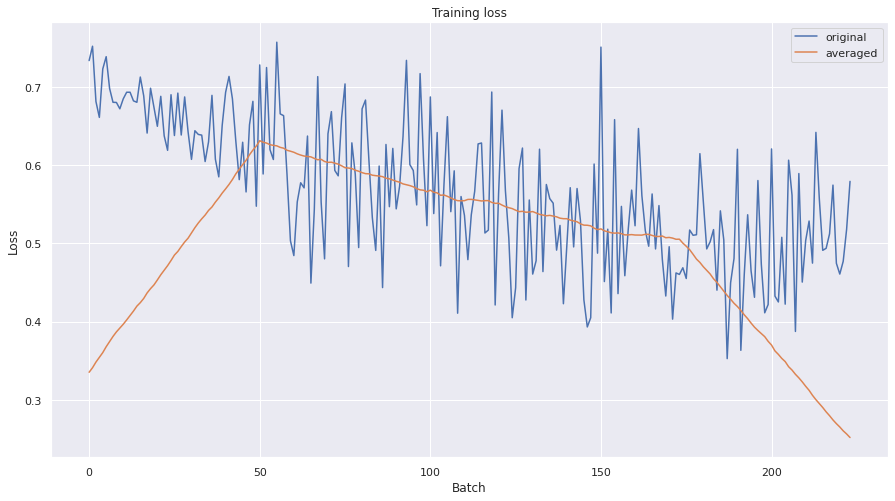

In [ ]:
%matplotlib inline
plt.figure(figsize=(15,8))
plt.title("Training loss")
plt.xlabel("Batch")
plt.ylabel("Loss")
plt.plot(train_lossv, label='original')
plt.plot(np.convolve(train_lossv, np.ones(101), 'same') / 101,
         label='averaged')
plt.legend(loc='best')
plt.show()